<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


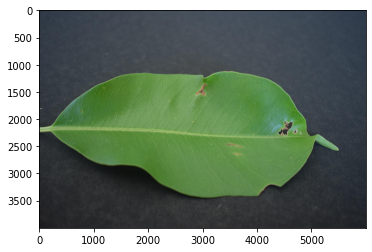

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

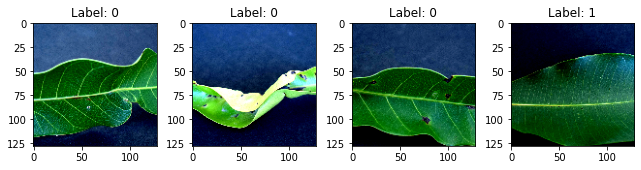

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2566674913511124 samples/sec                   batch loss = 0.41381895542144775 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2631824001511853 samples/sec                   batch loss = 0.740721583366394 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2583111442316361 samples/sec                   batch loss = 0.4621782600879669 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2214214929557858 samples/sec                   batch loss = 1.240836501121521 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.266626361434053 samples/sec                   batch loss = 0.40942543745040894 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2617055961416386 samples/sec                   batch loss = 0.47686728835105896 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2617848298368524 samples/sec                   batch loss = 0.5265704393386841 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2591574058584252 samples/sec                   batch loss = 0.43918532133102417 | accuracy = 0.6125


Epoch[1] Batch[45] Speed: 1.2642692656157324 samples/sec                   batch loss = 0.895420253276825 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2618005828711103 samples/sec                   batch loss = 0.441012978553772 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2614424408976674 samples/sec                   batch loss = 0.2187650352716446 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2601478072681433 samples/sec                   batch loss = 0.6151622533798218 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.257156678955077 samples/sec                   batch loss = 0.7394049167633057 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2567325374704024 samples/sec                   batch loss = 0.5071151256561279 | accuracy = 0.5821428571428572


Epoch[1] Batch[75] Speed: 1.2583250174848448 samples/sec                   batch loss = 0.34157732129096985 | accuracy = 0.5866666666666667


Epoch[1] Batch[80] Speed: 1.2689042517161413 samples/sec                   batch loss = 0.7845404148101807 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2690357449416978 samples/sec                   batch loss = 1.9033536911010742 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2634748265841562 samples/sec                   batch loss = 0.4232768714427948 | accuracy = 0.5944444444444444


Epoch[1] Batch[95] Speed: 1.2597189024180555 samples/sec                   batch loss = 0.4255818724632263 | accuracy = 0.5947368421052631


Epoch[1] Batch[100] Speed: 1.2643921767410151 samples/sec                   batch loss = 0.7980561256408691 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.2629858446832722 samples/sec                   batch loss = 0.6669727563858032 | accuracy = 0.5952380952380952


Epoch[1] Batch[110] Speed: 1.264396560059646 samples/sec                   batch loss = 0.16691137850284576 | accuracy = 0.5977272727272728


Epoch[1] Batch[115] Speed: 1.2689719145345524 samples/sec                   batch loss = 0.41250723600387573 | accuracy = 0.6108695652173913


Epoch[1] Batch[120] Speed: 1.2626322559592134 samples/sec                   batch loss = 1.6294198036193848 | accuracy = 0.6041666666666666


Epoch[1] Batch[125] Speed: 1.2676823812325277 samples/sec                   batch loss = 0.356802374124527 | accuracy = 0.612


Epoch[1] Batch[130] Speed: 1.255197702502298 samples/sec                   batch loss = 0.4921744465827942 | accuracy = 0.6134615384615385


Epoch[1] Batch[135] Speed: 1.2640591334273072 samples/sec                   batch loss = 0.3803413212299347 | accuracy = 0.6185185185185185


Epoch[1] Batch[140] Speed: 1.2610519895945196 samples/sec                   batch loss = 0.7985121011734009 | accuracy = 0.6232142857142857


Epoch[1] Batch[145] Speed: 1.2598600407157012 samples/sec                   batch loss = 0.23095259070396423 | accuracy = 0.6293103448275862


Epoch[1] Batch[150] Speed: 1.2570244336270124 samples/sec                   batch loss = 0.8009288907051086 | accuracy = 0.6283333333333333


Epoch[1] Batch[155] Speed: 1.259022471727141 samples/sec                   batch loss = 0.6122720241546631 | accuracy = 0.6274193548387097


Epoch[1] Batch[160] Speed: 1.2561700312851718 samples/sec                   batch loss = 0.5192553400993347 | accuracy = 0.6265625


Epoch[1] Batch[165] Speed: 1.257521722458028 samples/sec                   batch loss = 0.303661972284317 | accuracy = 0.6333333333333333


Epoch[1] Batch[170] Speed: 1.2601380583383006 samples/sec                   batch loss = 0.7799597382545471 | accuracy = 0.638235294117647


Epoch[1] Batch[175] Speed: 1.2579056519176872 samples/sec                   batch loss = 0.39631515741348267 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2612612179159486 samples/sec                   batch loss = 0.5606405735015869 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.264354538625432 samples/sec                   batch loss = 0.3803875148296356 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2543280564311017 samples/sec                   batch loss = 0.74471116065979 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.2580348753941384 samples/sec                   batch loss = 0.41861239075660706 | accuracy = 0.6525641025641026


Epoch[1] Batch[200] Speed: 1.257095450807192 samples/sec                   batch loss = 0.4575539231300354 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.2575571638834413 samples/sec                   batch loss = 0.30255815386772156 | accuracy = 0.6536585365853659


Epoch[1] Batch[210] Speed: 1.2563141384403365 samples/sec                   batch loss = 0.49409162998199463 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.2582135682228406 samples/sec                   batch loss = 0.7878684997558594 | accuracy = 0.6558139534883721


Epoch[1] Batch[220] Speed: 1.2590214324308098 samples/sec                   batch loss = 0.5419244170188904 | accuracy = 0.6579545454545455


Epoch[1] Batch[225] Speed: 1.2587679898453537 samples/sec                   batch loss = 0.7727684378623962 | accuracy = 0.6588888888888889


Epoch[1] Batch[230] Speed: 1.2537767886061055 samples/sec                   batch loss = 0.7165569067001343 | accuracy = 0.657608695652174


Epoch[1] Batch[235] Speed: 1.261430775056037 samples/sec                   batch loss = 0.6471755504608154 | accuracy = 0.6563829787234042


Epoch[1] Batch[240] Speed: 1.257227993716414 samples/sec                   batch loss = 0.5772479176521301 | accuracy = 0.65625


Epoch[1] Batch[245] Speed: 1.2585036983494664 samples/sec                   batch loss = 0.42277848720550537 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2576237162126203 samples/sec                   batch loss = 0.5319874882698059 | accuracy = 0.66


Epoch[1] Batch[255] Speed: 1.2557308589583982 samples/sec                   batch loss = 0.5252610445022583 | accuracy = 0.657843137254902


Epoch[1] Batch[260] Speed: 1.2531911818366182 samples/sec                   batch loss = 1.0783554315567017 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.2561759567108934 samples/sec                   batch loss = 0.5825071334838867 | accuracy = 0.6518867924528302


Epoch[1] Batch[270] Speed: 1.266137708607784 samples/sec                   batch loss = 0.4467383921146393 | accuracy = 0.6509259259259259


Epoch[1] Batch[275] Speed: 1.2601498895833882 samples/sec                   batch loss = 0.81305330991745 | accuracy = 0.6472727272727272


Epoch[1] Batch[280] Speed: 1.2590151022083922 samples/sec                   batch loss = 0.5274462699890137 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2668594455022235 samples/sec                   batch loss = 0.5559835433959961 | accuracy = 0.6482456140350877


Epoch[1] Batch[290] Speed: 1.2644040880038634 samples/sec                   batch loss = 0.6515309810638428 | accuracy = 0.6508620689655172


Epoch[1] Batch[295] Speed: 1.2641038021028292 samples/sec                   batch loss = 0.5747146606445312 | accuracy = 0.6533898305084745


Epoch[1] Batch[300] Speed: 1.263972662319175 samples/sec                   batch loss = 0.7479928731918335 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2596499529129583 samples/sec                   batch loss = 0.45037901401519775 | accuracy = 0.6516393442622951


Epoch[1] Batch[310] Speed: 1.260389401746823 samples/sec                   batch loss = 1.4612115621566772 | accuracy = 0.65


Epoch[1] Batch[315] Speed: 1.2605817400507593 samples/sec                   batch loss = 0.501856803894043 | accuracy = 0.6515873015873016


Epoch[1] Batch[320] Speed: 1.2594675426848676 samples/sec                   batch loss = 0.3045470416545868 | accuracy = 0.6515625


Epoch[1] Batch[325] Speed: 1.2572496629479724 samples/sec                   batch loss = 0.19565682113170624 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2561961788227682 samples/sec                   batch loss = 0.3714866638183594 | accuracy = 0.6530303030303031


Epoch[1] Batch[335] Speed: 1.2613990981680212 samples/sec                   batch loss = 0.563859224319458 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2613110940870178 samples/sec                   batch loss = 0.540175199508667 | accuracy = 0.6566176470588235


Epoch[1] Batch[345] Speed: 1.2524475303130653 samples/sec                   batch loss = 1.0618395805358887 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.2600201366304775 samples/sec                   batch loss = 0.8568798899650574 | accuracy = 0.6564285714285715


Epoch[1] Batch[355] Speed: 1.2586401265090714 samples/sec                   batch loss = 0.6279484033584595 | accuracy = 0.6542253521126761


Epoch[1] Batch[360] Speed: 1.2438569552520493 samples/sec                   batch loss = 0.6711557507514954 | accuracy = 0.6569444444444444


Epoch[1] Batch[365] Speed: 1.255090186610813 samples/sec                   batch loss = 0.6112589240074158 | accuracy = 0.6568493150684932


Epoch[1] Batch[370] Speed: 1.2632155933475469 samples/sec                   batch loss = 0.31913793087005615 | accuracy = 0.6587837837837838


Epoch[1] Batch[375] Speed: 1.247547507993288 samples/sec                   batch loss = 0.6350928544998169 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.257992709779787 samples/sec                   batch loss = 0.6867613196372986 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.2555323872970825 samples/sec                   batch loss = 0.2589050531387329 | accuracy = 0.6597402597402597


Epoch[1] Batch[390] Speed: 1.2601405192189798 samples/sec                   batch loss = 0.4058018922805786 | accuracy = 0.6602564102564102


Epoch[1] Batch[395] Speed: 1.263987803431897 samples/sec                   batch loss = 0.8061646223068237 | accuracy = 0.6588607594936708


Epoch[1] Batch[400] Speed: 1.2542394421939644 samples/sec                   batch loss = 1.1745024919509888 | accuracy = 0.66125


Epoch[1] Batch[405] Speed: 1.257973184378989 samples/sec                   batch loss = 0.8301698565483093 | accuracy = 0.658641975308642


Epoch[1] Batch[410] Speed: 1.258623224806704 samples/sec                   batch loss = 0.31590065360069275 | accuracy = 0.6591463414634147


Epoch[1] Batch[415] Speed: 1.255082863054246 samples/sec                   batch loss = 0.498470276594162 | accuracy = 0.6572289156626506


Epoch[1] Batch[420] Speed: 1.2590873839072136 samples/sec                   batch loss = 0.6087371110916138 | accuracy = 0.6589285714285714


Epoch[1] Batch[425] Speed: 1.2528990981512864 samples/sec                   batch loss = 0.6192700266838074 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.2605426236665653 samples/sec                   batch loss = 0.39085984230041504 | accuracy = 0.6604651162790698


Epoch[1] Batch[435] Speed: 1.2555432865744212 samples/sec                   batch loss = 0.6075050830841064 | accuracy = 0.6609195402298851


Epoch[1] Batch[440] Speed: 1.254072187642723 samples/sec                   batch loss = 0.5180758237838745 | accuracy = 0.6619318181818182


Epoch[1] Batch[445] Speed: 1.261265389915961 samples/sec                   batch loss = 0.3745361268520355 | accuracy = 0.6617977528089888


Epoch[1] Batch[450] Speed: 1.2645473266025842 samples/sec                   batch loss = 0.3334002196788788 | accuracy = 0.6638888888888889


Epoch[1] Batch[455] Speed: 1.2613306284152923 samples/sec                   batch loss = 0.4467751979827881 | accuracy = 0.6653846153846154


Epoch[1] Batch[460] Speed: 1.2574344470395096 samples/sec                   batch loss = 0.3511868119239807 | accuracy = 0.6652173913043479


Epoch[1] Batch[465] Speed: 1.2584435660547602 samples/sec                   batch loss = 0.7110764980316162 | accuracy = 0.6655913978494624


Epoch[1] Batch[470] Speed: 1.2553045793448228 samples/sec                   batch loss = 0.4685066044330597 | accuracy = 0.6638297872340425


Epoch[1] Batch[475] Speed: 1.26815267221733 samples/sec                   batch loss = 0.6757103204727173 | accuracy = 0.6652631578947369


Epoch[1] Batch[480] Speed: 1.2628140632786873 samples/sec                   batch loss = 1.137054204940796 | accuracy = 0.6661458333333333


Epoch[1] Batch[485] Speed: 1.2600276125521679 samples/sec                   batch loss = 0.3321264088153839 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.2555318235465052 samples/sec                   batch loss = 0.4953867197036743 | accuracy = 0.6683673469387755


Epoch[1] Batch[495] Speed: 1.2536313894438678 samples/sec                   batch loss = 1.1810694932937622 | accuracy = 0.6691919191919192


Epoch[1] Batch[500] Speed: 1.260633741133618 samples/sec                   batch loss = 0.5190699100494385 | accuracy = 0.669


Epoch[1] Batch[505] Speed: 1.2549941421394784 samples/sec                   batch loss = 0.49293234944343567 | accuracy = 0.6693069306930693


Epoch[1] Batch[510] Speed: 1.2622648096206859 samples/sec                   batch loss = 0.2634083032608032 | accuracy = 0.6696078431372549


Epoch[1] Batch[515] Speed: 1.2517571528379015 samples/sec                   batch loss = 0.8280113935470581 | accuracy = 0.670388349514563


Epoch[1] Batch[520] Speed: 1.2570155805888186 samples/sec                   batch loss = 0.6996176838874817 | accuracy = 0.6721153846153847


Epoch[1] Batch[525] Speed: 1.2532003555257567 samples/sec                   batch loss = 0.40419822931289673 | accuracy = 0.6738095238095239


Epoch[1] Batch[530] Speed: 1.2641745736526866 samples/sec                   batch loss = 0.9977981448173523 | accuracy = 0.6740566037735849


Epoch[1] Batch[535] Speed: 1.2581877140605184 samples/sec                   batch loss = 0.5174241065979004 | accuracy = 0.6742990654205607


Epoch[1] Batch[540] Speed: 1.2567158752324992 samples/sec                   batch loss = 0.5728520154953003 | accuracy = 0.6754629629629629


Epoch[1] Batch[545] Speed: 1.2610890521711469 samples/sec                   batch loss = 0.9275504350662231 | accuracy = 0.6738532110091743


Epoch[1] Batch[550] Speed: 1.2570258463574104 samples/sec                   batch loss = 0.5265792012214661 | accuracy = 0.6736363636363636


Epoch[1] Batch[555] Speed: 1.26319229135102 samples/sec                   batch loss = 0.5589672923088074 | accuracy = 0.6743243243243243


Epoch[1] Batch[560] Speed: 1.2609015814990985 samples/sec                   batch loss = 0.8675640821456909 | accuracy = 0.6736607142857143


Epoch[1] Batch[565] Speed: 1.2585785649508423 samples/sec                   batch loss = 1.8951047658920288 | accuracy = 0.6734513274336283


Epoch[1] Batch[570] Speed: 1.2554879465130258 samples/sec                   batch loss = 0.5322933793067932 | accuracy = 0.6732456140350878


Epoch[1] Batch[575] Speed: 1.2602012870908437 samples/sec                   batch loss = 0.8196585774421692 | accuracy = 0.672608695652174


Epoch[1] Batch[580] Speed: 1.2584100568298675 samples/sec                   batch loss = 0.13828147947788239 | accuracy = 0.6711206896551725


Epoch[1] Batch[585] Speed: 1.2559259147247988 samples/sec                   batch loss = 0.5574543476104736 | accuracy = 0.6717948717948717


Epoch[1] Batch[590] Speed: 1.2487111504890058 samples/sec                   batch loss = 0.609937310218811 | accuracy = 0.6741525423728814


Epoch[1] Batch[595] Speed: 1.2545132021289587 samples/sec                   batch loss = 0.3622921109199524 | accuracy = 0.6752100840336135


Epoch[1] Batch[600] Speed: 1.2540756560341326 samples/sec                   batch loss = 0.6298305988311768 | accuracy = 0.6741666666666667


Epoch[1] Batch[605] Speed: 1.2527804692717674 samples/sec                   batch loss = 0.3015185594558716 | accuracy = 0.6756198347107438


Epoch[1] Batch[610] Speed: 1.257337195402988 samples/sec                   batch loss = 0.497425377368927 | accuracy = 0.6774590163934426


Epoch[1] Batch[615] Speed: 1.2503464362268926 samples/sec                   batch loss = 0.4338873326778412 | accuracy = 0.6788617886178862


Epoch[1] Batch[620] Speed: 1.2598072520471135 samples/sec                   batch loss = 0.21731972694396973 | accuracy = 0.6806451612903226


Epoch[1] Batch[625] Speed: 1.263736355615668 samples/sec                   batch loss = 0.4411693513393402 | accuracy = 0.6804


Epoch[1] Batch[630] Speed: 1.259043163529418 samples/sec                   batch loss = 0.5186523199081421 | accuracy = 0.6797619047619048


Epoch[1] Batch[635] Speed: 1.2447535097783526 samples/sec                   batch loss = 0.3798203766345978 | accuracy = 0.6791338582677166


Epoch[1] Batch[640] Speed: 1.256793824417743 samples/sec                   batch loss = 0.8203030824661255 | accuracy = 0.678515625


Epoch[1] Batch[645] Speed: 1.2586157655405388 samples/sec                   batch loss = 0.2935202121734619 | accuracy = 0.6794573643410853


Epoch[1] Batch[650] Speed: 1.2410192219027272 samples/sec                   batch loss = 0.25336918234825134 | accuracy = 0.6811538461538461


Epoch[1] Batch[655] Speed: 1.2502801859932713 samples/sec                   batch loss = 0.4641372561454773 | accuracy = 0.6816793893129771


Epoch[1] Batch[660] Speed: 1.2423560579054727 samples/sec                   batch loss = 0.47668468952178955 | accuracy = 0.6821969696969697


Epoch[1] Batch[665] Speed: 1.253598135998217 samples/sec                   batch loss = 0.433682918548584 | accuracy = 0.6830827067669173


Epoch[1] Batch[670] Speed: 1.2578044611186585 samples/sec                   batch loss = 0.7358137965202332 | accuracy = 0.6824626865671641


Epoch[1] Batch[675] Speed: 1.2495046210296883 samples/sec                   batch loss = 0.5517542362213135 | accuracy = 0.6825925925925926


Epoch[1] Batch[680] Speed: 1.2613678022063615 samples/sec                   batch loss = 1.0194640159606934 | accuracy = 0.6827205882352941


Epoch[1] Batch[685] Speed: 1.2455428817736147 samples/sec                   batch loss = 0.476228803396225 | accuracy = 0.6828467153284672


Epoch[1] Batch[690] Speed: 1.2514106626095736 samples/sec                   batch loss = 0.5824374556541443 | accuracy = 0.6822463768115942


Epoch[1] Batch[695] Speed: 1.2546118937949595 samples/sec                   batch loss = 0.7846017479896545 | accuracy = 0.6834532374100719


Epoch[1] Batch[700] Speed: 1.2534289922603978 samples/sec                   batch loss = 0.4151221513748169 | accuracy = 0.6835714285714286


Epoch[1] Batch[705] Speed: 1.2524016248091319 samples/sec                   batch loss = 0.7825194597244263 | accuracy = 0.6836879432624113


Epoch[1] Batch[710] Speed: 1.2561627891740932 samples/sec                   batch loss = 0.5755826234817505 | accuracy = 0.6830985915492958


Epoch[1] Batch[715] Speed: 1.2560507822197546 samples/sec                   batch loss = 0.5712871551513672 | accuracy = 0.6835664335664335


Epoch[1] Batch[720] Speed: 1.256978851230373 samples/sec                   batch loss = 0.4990314543247223 | accuracy = 0.6836805555555555


Epoch[1] Batch[725] Speed: 1.261171147373585 samples/sec                   batch loss = 0.9489455223083496 | accuracy = 0.6834482758620689


Epoch[1] Batch[730] Speed: 1.2546422924547964 samples/sec                   batch loss = 0.34846383333206177 | accuracy = 0.6825342465753425


Epoch[1] Batch[735] Speed: 1.2592056036292154 samples/sec                   batch loss = 0.27686363458633423 | accuracy = 0.6819727891156463


Epoch[1] Batch[740] Speed: 1.259311462664264 samples/sec                   batch loss = 0.5595039129257202 | accuracy = 0.6817567567567567


Epoch[1] Batch[745] Speed: 1.2623149551510395 samples/sec                   batch loss = 0.762475848197937 | accuracy = 0.6812080536912751


Epoch[1] Batch[750] Speed: 1.2598759349447703 samples/sec                   batch loss = 0.4220030903816223 | accuracy = 0.682


Epoch[1] Batch[755] Speed: 1.2545982899335806 samples/sec                   batch loss = 0.44715309143066406 | accuracy = 0.6817880794701987


Epoch[1] Batch[760] Speed: 1.2578555731686223 samples/sec                   batch loss = 0.46654945611953735 | accuracy = 0.6819078947368421


Epoch[1] Batch[765] Speed: 1.2603668666835695 samples/sec                   batch loss = 0.6932690739631653 | accuracy = 0.6830065359477124


Epoch[1] Batch[770] Speed: 1.258799251377856 samples/sec                   batch loss = 0.9757575988769531 | accuracy = 0.6824675324675324


Epoch[1] Batch[775] Speed: 1.2554625800340542 samples/sec                   batch loss = 0.3429242968559265 | accuracy = 0.6829032258064516


Epoch[1] Batch[780] Speed: 1.260271338326779 samples/sec                   batch loss = 0.28010016679763794 | accuracy = 0.6833333333333333


Epoch[1] Batch[785] Speed: 1.2524611810712902 samples/sec                   batch loss = 0.6526263952255249 | accuracy = 0.6840764331210191


[Epoch 1] training: accuracy=0.6843274111675127
[Epoch 1] time cost: 657.0800457000732
[Epoch 1] validation: validation accuracy=0.7655555555555555


Epoch[2] Batch[5] Speed: 1.2619741769874746 samples/sec                   batch loss = 0.6536805629730225 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2551709391830115 samples/sec                   batch loss = 0.6202864646911621 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.262851514675934 samples/sec                   batch loss = 0.4062988758087158 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2512715976191466 samples/sec                   batch loss = 0.41022467613220215 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2620236349002174 samples/sec                   batch loss = 0.17360654473304749 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2614608411189585 samples/sec                   batch loss = 0.5911690592765808 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.2574218185546513 samples/sec                   batch loss = 0.2905523478984833 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2595482921730032 samples/sec                   batch loss = 0.6861969828605652 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2551891568973728 samples/sec                   batch loss = 0.2908017635345459 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2657259158137506 samples/sec                   batch loss = 1.0058534145355225 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2617677486779324 samples/sec                   batch loss = 0.4448549151420593 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2484158560538572 samples/sec                   batch loss = 0.7761741876602173 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.2474003966172145 samples/sec                   batch loss = 0.46012306213378906 | accuracy = 0.7115384615384616


Epoch[2] Batch[70] Speed: 1.2530554643740461 samples/sec                   batch loss = 0.7910325527191162 | accuracy = 0.7


Epoch[2] Batch[75] Speed: 1.2596817311709965 samples/sec                   batch loss = 0.6103179454803467 | accuracy = 0.7


Epoch[2] Batch[80] Speed: 1.2537901872619934 samples/sec                   batch loss = 0.27995678782463074 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2615917447829075 samples/sec                   batch loss = 0.3615635633468628 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.2519932981125046 samples/sec                   batch loss = 0.625410258769989 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2582146061858483 samples/sec                   batch loss = 0.6888284683227539 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2554339265407377 samples/sec                   batch loss = 0.8107154369354248 | accuracy = 0.71


Epoch[2] Batch[105] Speed: 1.2429490756014023 samples/sec                   batch loss = 0.8038836717605591 | accuracy = 0.7071428571428572


Epoch[2] Batch[110] Speed: 1.2501282376466387 samples/sec                   batch loss = 0.8372932076454163 | accuracy = 0.7


Epoch[2] Batch[115] Speed: 1.2393659273683444 samples/sec                   batch loss = 0.7244342565536499 | accuracy = 0.7021739130434783


Epoch[2] Batch[120] Speed: 1.2444625762943946 samples/sec                   batch loss = 0.3413880467414856 | accuracy = 0.7020833333333333


Epoch[2] Batch[125] Speed: 1.242558851738427 samples/sec                   batch loss = 0.7978315353393555 | accuracy = 0.702


Epoch[2] Batch[130] Speed: 1.2415005261342966 samples/sec                   batch loss = 0.8712586760520935 | accuracy = 0.7096153846153846


Epoch[2] Batch[135] Speed: 1.246209479493444 samples/sec                   batch loss = 1.460276484489441 | accuracy = 0.7074074074074074


Epoch[2] Batch[140] Speed: 1.2385520857710455 samples/sec                   batch loss = 0.31418243050575256 | accuracy = 0.7089285714285715


Epoch[2] Batch[145] Speed: 1.2463661247144973 samples/sec                   batch loss = 1.000686526298523 | accuracy = 0.7120689655172414


Epoch[2] Batch[150] Speed: 1.2446182286410734 samples/sec                   batch loss = 0.2009739875793457 | accuracy = 0.7133333333333334


Epoch[2] Batch[155] Speed: 1.2448629566513238 samples/sec                   batch loss = 0.22151276469230652 | accuracy = 0.7112903225806452


Epoch[2] Batch[160] Speed: 1.2506942952465283 samples/sec                   batch loss = 0.5244154930114746 | accuracy = 0.7140625


Epoch[2] Batch[165] Speed: 1.2371691350737986 samples/sec                   batch loss = 0.4837515354156494 | accuracy = 0.7151515151515152


Epoch[2] Batch[170] Speed: 1.231693487364127 samples/sec                   batch loss = 0.5350204110145569 | accuracy = 0.7102941176470589


Epoch[2] Batch[175] Speed: 1.235014117052096 samples/sec                   batch loss = 0.6216370463371277 | accuracy = 0.71


Epoch[2] Batch[180] Speed: 1.2459826359326756 samples/sec                   batch loss = 0.22747480869293213 | accuracy = 0.7097222222222223


Epoch[2] Batch[185] Speed: 1.2431794217441337 samples/sec                   batch loss = 0.34441447257995605 | accuracy = 0.7081081081081081


Epoch[2] Batch[190] Speed: 1.2460300154420472 samples/sec                   batch loss = 0.28025251626968384 | accuracy = 0.7118421052631579


Epoch[2] Batch[195] Speed: 1.2483036473479339 samples/sec                   batch loss = 0.27420493960380554 | accuracy = 0.717948717948718


Epoch[2] Batch[200] Speed: 1.2433683858852345 samples/sec                   batch loss = 0.6594207286834717 | accuracy = 0.71875


Epoch[2] Batch[205] Speed: 1.2433649764670065 samples/sec                   batch loss = 0.28248122334480286 | accuracy = 0.7195121951219512


Epoch[2] Batch[210] Speed: 1.2351877844835997 samples/sec                   batch loss = 0.2436242699623108 | accuracy = 0.7226190476190476


Epoch[2] Batch[215] Speed: 1.2489657658848765 samples/sec                   batch loss = 0.2625870704650879 | accuracy = 0.7267441860465116


Epoch[2] Batch[220] Speed: 1.2432141514585404 samples/sec                   batch loss = 0.3762170672416687 | accuracy = 0.7284090909090909


Epoch[2] Batch[225] Speed: 1.2371319143037065 samples/sec                   batch loss = 0.42732909321784973 | accuracy = 0.7288888888888889


Epoch[2] Batch[230] Speed: 1.2407159009410151 samples/sec                   batch loss = 0.2552424669265747 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.238198427876516 samples/sec                   batch loss = 0.275985449552536 | accuracy = 0.7340425531914894


Epoch[2] Batch[240] Speed: 1.2345355569551242 samples/sec                   batch loss = 0.3676065504550934 | accuracy = 0.7354166666666667


Epoch[2] Batch[245] Speed: 1.231555696071794 samples/sec                   batch loss = 0.12035255879163742 | accuracy = 0.7377551020408163


Epoch[2] Batch[250] Speed: 1.2427302291625186 samples/sec                   batch loss = 0.5789505243301392 | accuracy = 0.74


Epoch[2] Batch[255] Speed: 1.2392946105967373 samples/sec                   batch loss = 0.5148898363113403 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.2380014396553092 samples/sec                   batch loss = 0.5537956357002258 | accuracy = 0.739423076923077


Epoch[2] Batch[265] Speed: 1.234234579531038 samples/sec                   batch loss = 0.44152721762657166 | accuracy = 0.7396226415094339


Epoch[2] Batch[270] Speed: 1.2281903126555853 samples/sec                   batch loss = 0.554553747177124 | accuracy = 0.737037037037037


Epoch[2] Batch[275] Speed: 1.2432186655426936 samples/sec                   batch loss = 0.7933167815208435 | accuracy = 0.7363636363636363


Epoch[2] Batch[280] Speed: 1.2489508895487376 samples/sec                   batch loss = 0.37945112586021423 | accuracy = 0.7375


Epoch[2] Batch[285] Speed: 1.2400341768147563 samples/sec                   batch loss = 0.4255518615245819 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.2501976392679661 samples/sec                   batch loss = 0.578887939453125 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.2428792794311794 samples/sec                   batch loss = 0.4567912817001343 | accuracy = 0.7398305084745763


Epoch[2] Batch[300] Speed: 1.2477976584218526 samples/sec                   batch loss = 0.4210270941257477 | accuracy = 0.7391666666666666


Epoch[2] Batch[305] Speed: 1.2467454951615944 samples/sec                   batch loss = 0.3525455594062805 | accuracy = 0.7401639344262295


Epoch[2] Batch[310] Speed: 1.2453976294769658 samples/sec                   batch loss = 0.4682890772819519 | accuracy = 0.7403225806451613


Epoch[2] Batch[315] Speed: 1.2541149345621612 samples/sec                   batch loss = 0.26788538694381714 | accuracy = 0.7412698412698413


Epoch[2] Batch[320] Speed: 1.2521157027482603 samples/sec                   batch loss = 0.43466541171073914 | accuracy = 0.74140625


Epoch[2] Batch[325] Speed: 1.2697085141877145 samples/sec                   batch loss = 0.5854772329330444 | accuracy = 0.7415384615384616


Epoch[2] Batch[330] Speed: 0.9604090120777449 samples/sec                   batch loss = 0.2651766538619995 | accuracy = 0.7393939393939394


Epoch[2] Batch[335] Speed: 0.7798321102625737 samples/sec                   batch loss = 0.3672149181365967 | accuracy = 0.7402985074626866


Epoch[2] Batch[340] Speed: 0.7715002633560901 samples/sec                   batch loss = 0.30861279368400574 | accuracy = 0.7426470588235294


Epoch[2] Batch[345] Speed: 1.1680396659130703 samples/sec                   batch loss = 0.30559971928596497 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.247357735243272 samples/sec                   batch loss = 0.5017102956771851 | accuracy = 0.7442857142857143


Epoch[2] Batch[355] Speed: 1.240534805067664 samples/sec                   batch loss = 0.5390709042549133 | accuracy = 0.7450704225352113


Epoch[2] Batch[360] Speed: 1.2491407753924595 samples/sec                   batch loss = 0.4723045825958252 | accuracy = 0.7444444444444445


Epoch[2] Batch[365] Speed: 1.2357916360000023 samples/sec                   batch loss = 0.38817206025123596 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2469253507355107 samples/sec                   batch loss = 0.32970690727233887 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2517864793281432 samples/sec                   batch loss = 0.16685190796852112 | accuracy = 0.7446666666666667


Epoch[2] Batch[380] Speed: 1.2396048388371907 samples/sec                   batch loss = 0.17017106711864471 | accuracy = 0.7440789473684211


Epoch[2] Batch[385] Speed: 1.247078097288233 samples/sec                   batch loss = 0.3218718469142914 | accuracy = 0.7448051948051948


Epoch[2] Batch[390] Speed: 1.2436430436832056 samples/sec                   batch loss = 0.17117927968502045 | accuracy = 0.7442307692307693


Epoch[2] Batch[395] Speed: 1.2423856815505177 samples/sec                   batch loss = 0.5089842677116394 | accuracy = 0.7430379746835443


Epoch[2] Batch[400] Speed: 1.234933664666498 samples/sec                   batch loss = 0.8567755222320557 | accuracy = 0.741875


Epoch[2] Batch[405] Speed: 1.2411604245591392 samples/sec                   batch loss = 0.25814077258110046 | accuracy = 0.7407407407407407


Epoch[2] Batch[410] Speed: 1.248841187513059 samples/sec                   batch loss = 0.6007269620895386 | accuracy = 0.7420731707317073


Epoch[2] Batch[415] Speed: 1.2429578236953296 samples/sec                   batch loss = 0.2580380141735077 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.250526027369896 samples/sec                   batch loss = 0.5453667044639587 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.2435611866550413 samples/sec                   batch loss = 0.16976559162139893 | accuracy = 0.7476470588235294


Epoch[2] Batch[430] Speed: 1.2315078741498395 samples/sec                   batch loss = 0.6472730040550232 | accuracy = 0.747093023255814


Epoch[2] Batch[435] Speed: 1.2548540918995825 samples/sec                   batch loss = 0.8944087624549866 | accuracy = 0.7454022988505747


Epoch[2] Batch[440] Speed: 1.2412680465968555 samples/sec                   batch loss = 0.3812917470932007 | accuracy = 0.7460227272727272


Epoch[2] Batch[445] Speed: 1.248677692876429 samples/sec                   batch loss = 0.9570057392120361 | accuracy = 0.7460674157303371


Epoch[2] Batch[450] Speed: 1.2489259724796151 samples/sec                   batch loss = 0.49309465289115906 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2467670825030082 samples/sec                   batch loss = 0.2703762948513031 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.256004142057727 samples/sec                   batch loss = 0.27045509219169617 | accuracy = 0.7467391304347826


Epoch[2] Batch[465] Speed: 1.2392932374403418 samples/sec                   batch loss = 0.6034595370292664 | accuracy = 0.7483870967741936


Epoch[2] Batch[470] Speed: 1.2511209010042545 samples/sec                   batch loss = 0.17600807547569275 | accuracy = 0.7484042553191489


Epoch[2] Batch[475] Speed: 1.2408942962791698 samples/sec                   batch loss = 1.1296064853668213 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2502625763528215 samples/sec                   batch loss = 0.42456668615341187 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2434322468220884 samples/sec                   batch loss = 0.9092339873313904 | accuracy = 0.7515463917525773


Epoch[2] Batch[490] Speed: 1.2433471925074937 samples/sec                   batch loss = 0.18685424327850342 | accuracy = 0.7520408163265306


Epoch[2] Batch[495] Speed: 1.247343268135574 samples/sec                   batch loss = 0.34675177931785583 | accuracy = 0.752020202020202


Epoch[2] Batch[500] Speed: 1.2496111820475408 samples/sec                   batch loss = 0.812806248664856 | accuracy = 0.7505


Epoch[2] Batch[505] Speed: 1.247270659452509 samples/sec                   batch loss = 0.402353435754776 | accuracy = 0.7524752475247525


Epoch[2] Batch[510] Speed: 1.2540019802766125 samples/sec                   batch loss = 1.2096706628799438 | accuracy = 0.7509803921568627


Epoch[2] Batch[515] Speed: 1.2222905270753137 samples/sec                   batch loss = 0.27773022651672363 | accuracy = 0.7509708737864078


Epoch[2] Batch[520] Speed: 1.245455966716607 samples/sec                   batch loss = 0.07948923856019974 | accuracy = 0.7519230769230769


Epoch[2] Batch[525] Speed: 1.2482846073095397 samples/sec                   batch loss = 0.14048516750335693 | accuracy = 0.7519047619047619


Epoch[2] Batch[530] Speed: 1.243810386339124 samples/sec                   batch loss = 0.21096132695674896 | accuracy = 0.7528301886792453


Epoch[2] Batch[535] Speed: 1.2518505540842917 samples/sec                   batch loss = 0.511621356010437 | accuracy = 0.7542056074766356


Epoch[2] Batch[540] Speed: 1.2457479199128871 samples/sec                   batch loss = 0.28443992137908936 | accuracy = 0.7541666666666667


Epoch[2] Batch[545] Speed: 1.2426637710808301 samples/sec                   batch loss = 1.1548300981521606 | accuracy = 0.755045871559633


Epoch[2] Batch[550] Speed: 1.2523551617687323 samples/sec                   batch loss = 0.9126644730567932 | accuracy = 0.7554545454545455


Epoch[2] Batch[555] Speed: 1.237802961599312 samples/sec                   batch loss = 1.1176995038986206 | accuracy = 0.7558558558558559


Epoch[2] Batch[560] Speed: 1.2441959528889122 samples/sec                   batch loss = 0.09947030991315842 | accuracy = 0.7566964285714286


Epoch[2] Batch[565] Speed: 1.2425380540432291 samples/sec                   batch loss = 1.2106456756591797 | accuracy = 0.7561946902654867


Epoch[2] Batch[570] Speed: 1.2445401206395386 samples/sec                   batch loss = 0.24434015154838562 | accuracy = 0.7557017543859649


Epoch[2] Batch[575] Speed: 1.2528518497305063 samples/sec                   batch loss = 0.5717153549194336 | accuracy = 0.7552173913043478


Epoch[2] Batch[580] Speed: 1.2444406994590902 samples/sec                   batch loss = 0.7703800797462463 | accuracy = 0.7556034482758621


Epoch[2] Batch[585] Speed: 1.2570225499914212 samples/sec                   batch loss = 0.17318442463874817 | accuracy = 0.755982905982906


Epoch[2] Batch[590] Speed: 1.2412587712665575 samples/sec                   batch loss = 0.4760713279247284 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.2567059910628733 samples/sec                   batch loss = 0.640435516834259 | accuracy = 0.7558823529411764


Epoch[2] Batch[600] Speed: 1.2490798605682396 samples/sec                   batch loss = 0.7348859310150146 | accuracy = 0.7558333333333334


Epoch[2] Batch[605] Speed: 1.241550413572235 samples/sec                   batch loss = 0.37758857011795044 | accuracy = 0.7549586776859504


Epoch[2] Batch[610] Speed: 1.2571712803941428 samples/sec                   batch loss = 0.4436735510826111 | accuracy = 0.7549180327868853


Epoch[2] Batch[615] Speed: 1.233015371300634 samples/sec                   batch loss = 0.22059689462184906 | accuracy = 0.7548780487804878


Epoch[2] Batch[620] Speed: 1.2518247739476958 samples/sec                   batch loss = 0.4790891706943512 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2406853476259154 samples/sec                   batch loss = 0.3662581145763397 | accuracy = 0.7572


Epoch[2] Batch[630] Speed: 1.2475571558531815 samples/sec                   batch loss = 0.47966429591178894 | accuracy = 0.7579365079365079


Epoch[2] Batch[635] Speed: 1.2508278230865981 samples/sec                   batch loss = 0.374360054731369 | accuracy = 0.7582677165354331


Epoch[2] Batch[640] Speed: 1.238031678208296 samples/sec                   batch loss = 0.19828185439109802 | accuracy = 0.75859375


Epoch[2] Batch[645] Speed: 1.2433498646761862 samples/sec                   batch loss = 0.19843417406082153 | accuracy = 0.7593023255813953


Epoch[2] Batch[650] Speed: 1.2351215850638273 samples/sec                   batch loss = 0.3636748194694519 | accuracy = 0.7588461538461538


Epoch[2] Batch[655] Speed: 1.239557305606381 samples/sec                   batch loss = 0.4651395380496979 | accuracy = 0.7591603053435114


Epoch[2] Batch[660] Speed: 1.242560416194982 samples/sec                   batch loss = 0.9474166035652161 | accuracy = 0.7571969696969697


Epoch[2] Batch[665] Speed: 1.2433179836883406 samples/sec                   batch loss = 0.5291461944580078 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.2534790001076617 samples/sec                   batch loss = 0.6044027209281921 | accuracy = 0.7555970149253731


Epoch[2] Batch[675] Speed: 1.236531765050639 samples/sec                   batch loss = 0.3719111680984497 | accuracy = 0.7562962962962962


Epoch[2] Batch[680] Speed: 1.2437051810992161 samples/sec                   batch loss = 0.3720364272594452 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2530097950391548 samples/sec                   batch loss = 0.48860031366348267 | accuracy = 0.7554744525547445


Epoch[2] Batch[690] Speed: 1.2395912837100282 samples/sec                   batch loss = 0.9618768692016602 | accuracy = 0.7547101449275362


Epoch[2] Batch[695] Speed: 1.2378788561842642 samples/sec                   batch loss = 0.3822588622570038 | accuracy = 0.7550359712230216


Epoch[2] Batch[700] Speed: 1.2360835377482837 samples/sec                   batch loss = 0.2600146234035492 | accuracy = 0.7564285714285715


Epoch[2] Batch[705] Speed: 1.2442217888559743 samples/sec                   batch loss = 0.8043020367622375 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.2458100828304155 samples/sec                   batch loss = 0.9527146816253662 | accuracy = 0.7563380281690141


Epoch[2] Batch[715] Speed: 1.2463656617568946 samples/sec                   batch loss = 0.3005646765232086 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2539647707479653 samples/sec                   batch loss = 0.49090930819511414 | accuracy = 0.7569444444444444


Epoch[2] Batch[725] Speed: 1.2575861029117499 samples/sec                   batch loss = 0.5883663296699524 | accuracy = 0.7572413793103449


Epoch[2] Batch[730] Speed: 1.250383338135463 samples/sec                   batch loss = 0.25705209374427795 | accuracy = 0.7585616438356164


Epoch[2] Batch[735] Speed: 1.2554894497439515 samples/sec                   batch loss = 0.2668364644050598 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.2470462102086852 samples/sec                   batch loss = 0.6486988067626953 | accuracy = 0.7587837837837837


Epoch[2] Batch[745] Speed: 1.2447954390486937 samples/sec                   batch loss = 0.3150116801261902 | accuracy = 0.758724832214765


Epoch[2] Batch[750] Speed: 1.2542428177450236 samples/sec                   batch loss = 0.24600431323051453 | accuracy = 0.7596666666666667


Epoch[2] Batch[755] Speed: 1.250773457403612 samples/sec                   batch loss = 0.7386026978492737 | accuracy = 0.7589403973509934


Epoch[2] Batch[760] Speed: 1.2378888117600948 samples/sec                   batch loss = 0.5886316299438477 | accuracy = 0.7588815789473684


Epoch[2] Batch[765] Speed: 1.2381682725549887 samples/sec                   batch loss = 0.3578251004219055 | accuracy = 0.7588235294117647


Epoch[2] Batch[770] Speed: 1.25371851246947 samples/sec                   batch loss = 0.4122409522533417 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2594555351558632 samples/sec                   batch loss = 0.47264355421066284 | accuracy = 0.7596774193548387


Epoch[2] Batch[780] Speed: 1.2401806558554445 samples/sec                   batch loss = 0.4084211587905884 | accuracy = 0.7592948717948718


Epoch[2] Batch[785] Speed: 1.2339612477756696 samples/sec                   batch loss = 1.0746465921401978 | accuracy = 0.7595541401273885


[Epoch 2] training: accuracy=0.7592005076142132
[Epoch 2] time cost: 656.9404535293579
[Epoch 2] validation: validation accuracy=0.7688888888888888


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.74

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)